In [38]:
import copy
import torch
import numpy as np
import pandas as pd
import xgboost as xgb
import torch.nn as nn
import lightgbm as lgb
import torch.optim as optim
from sklearn import metrics
from sklearn import datasets
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_auc_score

In [13]:
data = pd.read_csv('train.csv')
quiz = pd.read_csv('test_data.csv')

In [14]:

drop_out = [data.columns[0]]
for i in data.columns[5:]:
    if 1-len(data[data[i].notna()])/len(data)>0.3:
        drop_out.append(i)
print(drop_out)
data = data.drop(columns=drop_out)
quiz = quiz.drop(columns=drop_out)
data

['Unnamed: 0', 'COL13', 'COL14', 'COL21', 'COL25', 'COL31', 'COL37', 'COL45', 'COL46', 'COL52']


ID  CHANNEL_A  CHANNEL_B  CHANNEL_C   COL1  COL2 COL3 COL4 COL5  \
0      T000689          0          0          0    NaN    58    A    B    E   
1      T000848          0          1          0    6.0    49    B    B    C   
2      T000967          0          0          0    NaN    55    B    A    C   
3      T001249          0          0          0   17.0    36    K    A    B   
4      T001524          0          1          0   22.0    43  NaN  NaN    B   
...        ...        ...        ...        ...    ...   ...  ...  ...  ...   
99995  T034492          0          1          0    NaN    30    K    A    A   
99996  T034682          0          0          0    4.0    49    Z    B    B   
99997  T035207          0          0          0   18.0    30    B    A    A   
99998  T035311          0          0          0  347.0    33    B    B    A   
99999  T037255          0          1          0    NaN    34    B    B    B   

        COL6  ...  COL42  COL43  COL44  COL47  COL48  COL49  COL50  COL51  \
0       0.00  ...   0.00   3.09    0.0   0.00    0.0    2.0  11.23  318.0   
1       0.00  ... -37.56  59.94    0.0   0.00    0.0    4.0  48.20    NaN   
2       0.00  ...  24.66  10.00    0.0   0.00    1.0    1.0  36.84   49.0   
3       0.00  ...   0.00  24.16    0.0  23.82    0.0    0.0   0.00   49.0   
4       0.00  ...   0.00  26.30    0.0   0.00    0.0    0.0   0.00   17.0   
...      ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
99995   0.00  ...   0.00   0.00    0.0   0.00    0.0    0.0   0.00    NaN   
99996   0.00  ...   0.00  20.88    1.0   0.00    1.0    0.0   0.00    4.0   
99997  60.78  ...   0.00  20.29    1.0  24.80    1.0    0.0   0.00   17.0   
99998   9.74  ...   0.00  28.36    1.0   0.00    1.0    0.0   0.00  292.0   
99999  58.43  ...  14.42  11.67    1.0  40.96    1.0    0.0   0.00   12.0   

       COL53  COL54  
0        0.0    0.0  
1        0.0    0.0  
2        0.0    0.0  
3        1.0    0.0  
4        0.0    0.0  
...      ...    ...  
99995    0.0    0.0  
99996    0.0    0.0  
99997    0.0    3.0  
99998    0.0    0.0  
99999    0.0    0.0  

[100000 rows x 49 columns]

In [15]:
Alpha = [chr(ord('A')+i) for i in range(26)]
IDs = [[i] for i in quiz['ID']]

In [16]:
class_mapping = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'I':9,'J':10,'K':11,'L':12,'M':13,'N':14,'O':15,'P':16,'Q':17,'R':18,'S':19,'T':20,'U':21,'V':22,'W':23,'X':24,'Y':25,'Z':26}
names = ['COL3', 'COL4','COL5','COL19']
one_hot = []
# onehot
for name in names:
    if name in data.columns:
        temp_pd = pd.get_dummies(list(data[name])+Alpha,dtype=int)[:-26]
        temp_pd.columns = [i + name[-1] for i in list(temp_pd.columns)]
        data = pd.concat([data.drop(columns=[name]), temp_pd],axis=1)
        
        temp_pd = pd.get_dummies(list(quiz[name])+Alpha,dtype=int)[:-26]
        temp_pd.columns = [i + name[-1] for i in list(temp_pd.columns)]
        quiz = pd.concat([quiz.drop(columns=[name]), temp_pd],axis=1)
        one_hot.extend(temp_pd.columns)
# print(pd.get_dummies(list(data[names[3]])))
# print(enc.fit_transform(data[names[0]]))
# for name in names:
#     if name in data.columns:
#         data[name] = data[name].map(class_mapping)
#         quiz[name] = quiz[name].map(class_mapping)

for name in data.columns[1:]:
        data[name] = data[name].fillna(data[name].mean())
for name in quiz.columns[1:]:
        quiz[name] = quiz[name].fillna(quiz[name].mean())
data

ID  CHANNEL_A  CHANNEL_B  CHANNEL_C        COL1  COL2   COL6  \
0      T000689          0          0          0   28.102886    58   0.00   
1      T000848          0          1          0    6.000000    49   0.00   
2      T000967          0          0          0   28.102886    55   0.00   
3      T001249          0          0          0   17.000000    36   0.00   
4      T001524          0          1          0   22.000000    43   0.00   
...        ...        ...        ...        ...         ...   ...    ...   
99995  T034492          0          1          0   28.102886    30   0.00   
99996  T034682          0          0          0    4.000000    49   0.00   
99997  T035207          0          0          0   18.000000    30  60.78   
99998  T035311          0          0          0  347.000000    33   9.74   
99999  T037255          0          1          0   28.102886    34  58.43   

       COL7  COL8        COL9  ...  Q9  R9  S9  T9  U9  V9  W9  X9  Y9  Z9  
0         0     1   65.718368  ...   0   0   0   0   0   0   0   0   0   0  
1         0     1   24.000000  ...   0   0   0   0   0   0   0   0   0   0  
2         0     1   65.718368  ...   0   0   0   0   0   0   0   0   0   0  
3         0     0   41.000000  ...   0   0   0   0   0   0   0   0   0   0  
4         1     0   52.000000  ...   0   0   0   0   0   0   0   0   0   0  
...     ...   ...         ...  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
99995     0     0   65.718368  ...   0   0   0   0   0   0   0   0   0   0  
99996     0     0   29.000000  ...   0   0   0   0   0   0   0   0   0   0  
99997     0     0   40.000000  ...   0   0   0   0   0   0   0   0   0   0  
99998     2     1  377.000000  ...   0   0   0   0   0   0   0   0   0   0  
99999     2     0   65.718368  ...   0   0   0   0   0   0   0   0   0   0  

[100000 rows x 149 columns]

In [17]:
def get_adv_feats(df_train, df_test, feats):
    l_train = [1 for i in range(len(df_train))]
    adv_train = pd.DataFrame(l_train,columns=['adv'])
    df_train = pd.concat([df_train.reset_index(drop=True),adv_train],axis=1).reset_index(drop=True).sample(len(df_test),replace=True)
    l_test = [0 for i in range(len(df_test))]
    adv_test = pd.DataFrame(l_test,columns=['adv'])
    df_test = pd.concat([df_test.reset_index(drop=True),adv_test],axis=1).reset_index(drop=True)
    df = pd.concat([df_train, df_test]).reset_index(drop=True)
    params = {
        'learning_rate': 0.05,
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'n_jobs': 4,
        'verbose': -1,
    }
    fold_num = 5
    steps = 3
    new_feats = []
    for f in feats:
        kf = StratifiedKFold(n_splits=fold_num, shuffle=True)
        for fold, (train_idx, val_idx) in enumerate(kf.split(df[[f]], df['adv'])):
            train = lgb.Dataset(df.loc[train_idx, [f]],
                                df.loc[train_idx, 'adv'])
            val = lgb.Dataset(df.loc[val_idx, [f]],
                              df.loc[val_idx, 'adv'])
            model = lgb.train(params, train, valid_sets=[val], num_boost_round=10000,  # feval=recall_score,
                              callbacks=[lgb.early_stopping(100), lgb.log_evaluation(-1)])
            x = model.predict(df.loc[val_idx, [f]])
            score = roc_auc_score(df.loc[val_idx, 'adv'], x)
            print(f,' --- ', score)
            if score > 0.8:
                new_feats.append(f)
                print('--------------------------------------', f, score)
            break
    return new_feats

# print(data.drop(columns=['CHANNEL_A','CHANNEL_B','CHANNEL_C']).columns == quiz.columns)
feats = quiz.drop(columns=['ID']).columns[:41]
del_feats = get_adv_feats(data.drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']).sample(n=(10000),replace=True),
                      quiz.drop(columns=['ID']).sample(n=(10000),replace=True), feats)
print(del_feats)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[308]	valid_0's auc: 0.93374
COL1  ---  0.9337398750000002
-------------------------------------- COL1 0.9337398750000002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.598603
COL2  ---  0.59860275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's auc: 0.518372
COL6  ---  0.51837225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.513601
COL7  ---  0.5136008750000001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.5265
COL8  ---  0.5265000000000001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's auc: 0.90641
COL9  ---  0.906409875
----------------------------

In [18]:
for drop_col in del_feats:
    if drop_col in data.columns:
        data = data.drop(columns=[drop_col])
    if drop_col in quiz.columns:
        quiz = quiz.drop(columns=[drop_col])

In [19]:
# resampling
Attributes = ['CHANNEL_A','CHANNEL_B','CHANNEL_C']
balance_data = {}

def resample(df, Attribute, length):
    pos_df = df[df[Attribute] == 1].sample(int(length/2),replace=True).reset_index(drop=True)
    neg_df = df[df[Attribute] == 0].sample(int(length/2),replace=True).reset_index(drop=True)
    new_df = pd.concat([pos_df,neg_df],axis=0).reset_index(drop=True)
    return new_df

In [20]:
from sklearn.model_selection import train_test_split
dat_train = {}
dat_test = {}
dat_vali = {}
for i in Attributes:
    dat_train_vali, dat_test[i] = train_test_split(data, test_size=0.2, shuffle=True)
    dat_train[i], dat_vali[i] = train_test_split(dat_train_vali, test_size=0.1, shuffle=True)
    dat_train[i] = resample(dat_train[i], i, 500000)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
Train_x = {}
Train_y = {}
Vali_x = {}
Vali_y = {}
Test_x = {}
Test_y = {}
Q = {}
scaler = StandardScaler()
# scaler = MinMaxScaler()

for i in Attributes:    
    Train_x[i] = pd.DataFrame(scaler.fit_transform(dat_train[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot)),
                           columns=dat_train[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot).columns)
    Train_x[i] = pd.concat([Train_x[i],dat_train[i][one_hot].reset_index(drop=True)],axis=1)

    Train_y[i] = pd.DataFrame(dat_train[i][i].reset_index(drop=True))
    
    Vali_x[i] = pd.DataFrame(scaler.transform(dat_vali[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot)),
                            columns=dat_train[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot).columns)
    Vali_x[i] = pd.concat([Vali_x[i],dat_vali[i][one_hot].reset_index(drop=True)],axis=1)
    
    Vali_y[i] = pd.DataFrame(dat_vali[i][i].reset_index(drop=True))
    
    Test_x[i] = pd.DataFrame(scaler.transform(dat_test[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot)),
                           columns=dat_test[i].drop(columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C']+one_hot).columns)
    Test_x[i] = pd.concat([Test_x[i],dat_test[i][one_hot].reset_index(drop=True)],axis=1)
        
    Test_y[i] = pd.DataFrame(dat_test[i][i].reset_index(drop=True))
    
    Q[i] = pd.DataFrame(scaler.transform(quiz.drop(columns=['ID']+one_hot)),
                           columns=quiz.drop(columns=['ID']+one_hot).columns)
    Q[i] = pd.concat([Q[i],quiz[one_hot].reset_index(drop=True)],axis=1)

In [22]:
train_x = {}
train_y = {}
vali_x = {}
vali_y = {}
test_x = {}
test_y = {}
q = {}
for i in Attributes:    
    train_x[i] = torch.tensor(Train_x[i].values).float()
    train_y[i] = torch.tensor(Train_y[i].values).float()
    vali_x[i] = torch.tensor(Vali_x[i].values).float()
    vali_y[i] = torch.tensor(Vali_y[i].values).float()
    test_x[i] = torch.tensor(Test_x[i].values).float()
    test_y[i] = torch.tensor(Test_y[i].values).float()
    q[i] = torch.tensor(Q[i].values).float()

In [23]:
Attributes = ['CHANNEL_A','CHANNEL_B','CHANNEL_C']
for i in Attributes:
    class_weights = {0: len(Train_y[i])-Train_y[i][i].sum(), 1: Train_y[i][i].sum()}
    pos_weight = class_weights[0] / class_weights[1]
    print(pos_weight,end='  ')
    class_weights = {0: len(Vali_y[i])-Vali_y[i][i].sum(), 1: Vali_y[i][i].sum()}
    pos_weight = class_weights[0] / class_weights[1]
    print(pos_weight, end='  ')
    class_weights = {0: len(Test_y[i])-Test_y[i][i].sum(), 1: Test_y[i][i].sum()}
    pos_weight = class_weights[0] / class_weights[1]
    print(pos_weight)

1.0  17.51851851851852  17.779342723004696
1.0  2.848003848003848  2.9517881841533296
1.0  124.0  111.99435028248588


In [24]:
class FNN_BC(nn.Module): 
    def __init__(self,n_in=5, n_hidden=1, n_units=10):
        super().__init__()   
        self.hidden=[]  # initialize as empty list
        self.act=[]
        for i in range(n_hidden):
            if i==0:
                self.hidden.append(nn.Linear(n_in, n_units))
            else:
                self.hidden.append(nn.Linear(n_units, n_units))  # append a new element to the list
            self.act.append(nn.ReLU())
            self.add_module(f"hidden{i+1}", self.hidden[-1])  
            # add a child module to the current module with name hidden{i+1} where i+1 is replaced by its numerical value
            nn.init.kaiming_uniform_(self.hidden[-1].weight, mode="fan_in", nonlinearity="relu")
            self.add_module(f"act{i+1}", self.act[-1])
            # add a child module to the current module with name act{i+1} where i+1 is replaced by its numerical value
        self.out = nn.Linear(n_units, 1)
        nn.init.xavier_uniform_(self.out.weight)
        self.act_out = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(len(self.hidden)):
            x = self.act[i](self.hidden[i](x))
        x = self.act_out(self.out(x)) 
        return x

In [25]:
trainset = {}
valiset = {}
testset = {}
for i in Attributes:
    trainset[i] = torch.utils.data.TensorDataset(train_x[i], train_y[i])
    valiset[i] = torch.utils.data.TensorDataset(vali_x[i], vali_y[i])
    testset[i] = torch.utils.data.TensorDataset(test_x[i], test_y[i])

In [26]:
def checkpoint(model, optimizer, filename):
    torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, filename)

def resume(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [33]:
def train_nn(attribute, model, optimizer, loss_fn, dataloader, max_epochs=500, early_stop_thresh=100, scheduler=None, verbose=1):
    loss_train = []  # this list records the training loss from every epoch
    loss_vali = [] # this list records the validation loss from every epoch
    f1_vali = [] # this list records the classificaiton accuracy on the validation set from every epoch
    best_f1 = -1
    best_epoch = -1
    for epoch in range(max_epochs):
        # Enter the training mode
        model.train()
        for data in dataloader:
            # data is a list of [x vars, y var]
            x, y = data
            # Reset the gradient to None (default) because PyTorch accumulates the gradients on subsequence backward passes.
            optimizer.zero_grad()
            # Obtain the predicted probabilities from the model
            proba = model(x)
            # Calculate the loss 
            loss = loss_fn(proba, y)
            # Calculate the gradient by backward propagation
            loss.backward()  
            # Use the optimizer to update the model parameters by one step
            optimizer.step()        
        # Reduce the learning rate using the scheduler if it is not None. 
        if scheduler!=None:
            scheduler.step(metrics=loss)  
        # Append the loss of the current epoch to the list loss_train
        loss_train.append(loss.detach().numpy())
        # Enter the evaluation mode
        model.eval()
        x_vali, y_vali = valiset[attribute][:]
        y_pred = model(x_vali)
        loss_new = loss_fn(y_pred, y_vali)
        loss_vali.append(loss_new.detach().numpy())
        f1 = roc_auc_score(y_pred.round().detach().numpy(), 
                           y_vali.detach().numpy())
        f1_vali.append(f1)
        # print the loss after one epoch is done
        if verbose==1:
            print(f'Finished epoch {epoch}:', 'loss_train = %.4f' %loss, 'loss_vali = %.4f' %loss_new, 'f1_vali = %.4f' %f1, sep=', ')
        if f1 > best_f1:
            best_f1 = f1
            best_epoch = epoch
            checkpoint(model, optimizer, attribute+'best_model.pt')
        elif epoch - best_epoch > early_stop_thresh:
            print(f'Early stopped training at epoch {epoch}')
            break # terminate the training loop
    print('Training finished, best f1 = %.4f' %best_f1, 'best epoch = %d' %best_epoch, sep=', ')
    return loss_train, loss_vali, f1_vali, best_f1, best_epoch

In [34]:
def test_perf(model, testset, ax=None):
    model.eval()                 # enter the evaluation mode, so no changes made to the model
    with torch.no_grad():        # don't calculate gradient
        num_threshold = 101
        threshold = np.linspace(0, 1, num_threshold)
        tp = np.zeros_like(threshold)
        tn = np.zeros_like(threshold)
        fp = np.zeros_like(threshold)
        fn = np.zeros_like(threshold)

        x, y = testset[:]
        y = y.data.numpy()  # convert from pytorch tensor to numpy array
        proba = model(x).data.numpy()
        y_pred = proba > threshold  # broadcasting to get a 2D array of size 200*101
        for i in range(num_threshold):
            tn[i], fp[i], fn[i], tp[i] = skm.confusion_matrix(y, y_pred[:,i]).ravel()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        i = np.where(threshold==0.5)[0][0]  # i is the index for threshold = 0.5
        accuracy = (tn[i] + tp[i]) / y.shape[0]
        print("accuracy:", accuracy.round(decimals=4))

        precision = tp[i] / (tp[i] + fp[i]) 
        print("precision:", precision.round(decimals=4))
        
        recall = tpr[i]
        print("recall:", recall.round(decimals=4))
        
        AUC = -np.trapz(y=tpr,x=fpr)
        AUC_4 = AUC.round(decimals=4)
        print("AUC:", AUC_4)
        
        if ax!=None:
            ax.plot(fpr, tpr, label=f'AUC={AUC_4}')
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])

        f1 = 2*precision*recall/(precision+recall)
        print("F1:", f1)
        return f1, accuracy, precision, recall, AUC

In [44]:
def Train(attribute):
    trainloader = torch.utils.data.DataLoader(trainset[attribute], batch_size=64, shuffle=True)
    # We create a feedforward neural network for binary classification using 2 hidden layers and 100 neurons on each hidden layer.
    model = FNN_BC(n_in=137, n_hidden=3, n_units=10)
    # We use the binary cross entropy loss as the loss function for training, which is equivalent to the negative log-likelihood.
    loss_fn = nn.BCELoss() 
    # We use the Adam optimizer. The first argument tells the optimizer to optimize over the parameters of the neural network model.
    # lr is for learning rate. 
    optimizer = optim.Adam(model.parameters(), lr=0.01)
#     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     Set a scheduler to reduce the learning rate
    scheduler = None
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', verbose=True)
#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#     scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400], gamma=0.1)
    
    loss_train, loss_vali, f1_vali, best_f1, best_epoch = train_nn(attribute, model, optimizer, loss_fn, trainloader, 
                                                                      5, 5, scheduler)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    for i in range(2):
        if i==0:
            ax[i].plot(range(len(loss_train)), loss_train, label='train')
            ax[i].plot(range(len(loss_vali)), loss_vali, label='validation')
            ax[i].set_title("Training and validation loss")
            ax[i].set_xlabel("epoch")
            ax[i].set_ylabel("loss")
            ax[i].legend();
        else:
            ax[i].plot(range(len(f1_vali)), f1_vali)
            ax[i].set_title("Validation f1")
            ax[i].set_xlabel("epoch")
            ax[i].set_ylabel("accuracy")
    resume(model, optimizer, attribute+"best_model.pt")
    model.eval()
    pred = model(q[attribute])
    ans.append(list(pred.round().detach().numpy()))
    
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")

    print("FNN_BC:")
    f1, accuracy, precision, recall, AUC = test_perf(model, testset[attribute], ax)
    ax.legend();

Finished epoch 0:, loss_train = 0.6026, loss_vali = 0.6545, f1_vali = 0.5133
Finished epoch 1:, loss_train = 0.6140, loss_vali = 0.6894, f1_vali = 0.5111
Finished epoch 2:, loss_train = 0.5751, loss_vali = 0.6550, f1_vali = 0.5132
Finished epoch 3:, loss_train = 0.8210, loss_vali = 0.7117, f1_vali = 0.5139
Finished epoch 4:, loss_train = 0.6078, loss_vali = 0.6652, f1_vali = 0.5138
Training finished, best f1 = 0.5139, best epoch = 3
FNN_BC:
accuracy: 0.5644
precision: 0.0682
recall: 0.5671
AUC: 0.569
F1: 0.12176191916137484
CHANNEL_A Finished
Finished epoch 0:, loss_train = 0.6714, loss_vali = 0.6647, f1_vali = 0.5923
Finished epoch 1:, loss_train = 0.5634, loss_vali = 0.6454, f1_vali = 0.5974
Finished epoch 2:, loss_train = 0.6877, loss_vali = 0.6797, f1_vali = 0.5819
Finished epoch 3:, loss_train = 0.6388, loss_vali = 0.6531, f1_vali = 0.5919
Finished epoch 4:, loss_train = 0.6823, loss_vali = 0.6918, f1_vali = 0.5942
Training finished, best f1 = 0.5974, best epoch = 1
FNN_BC:
accura

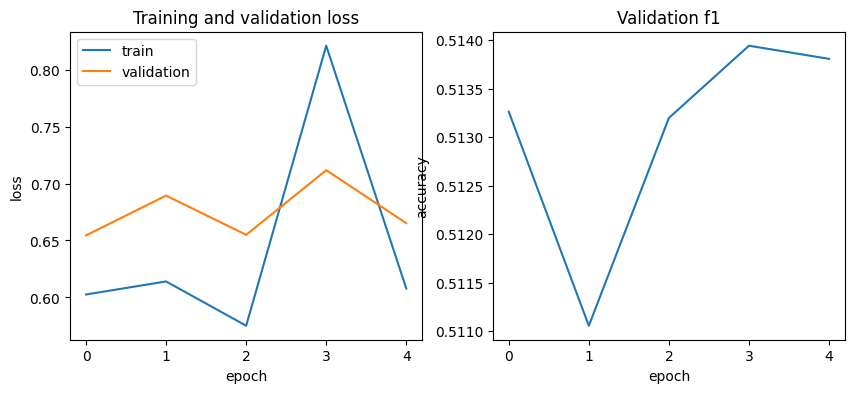

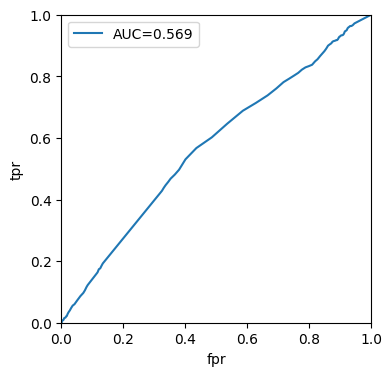

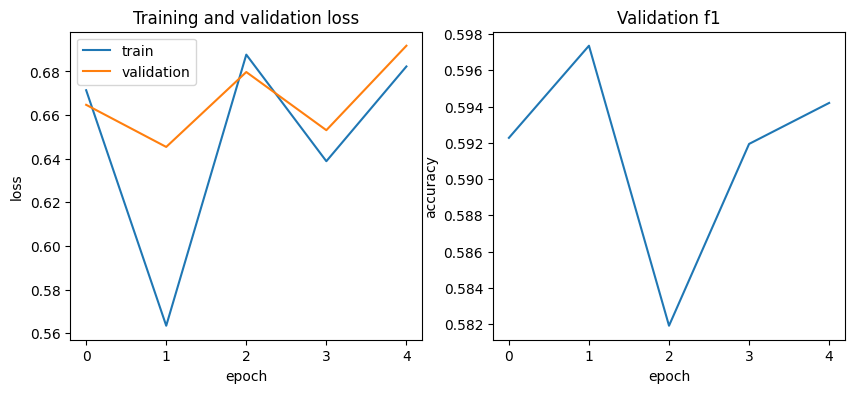

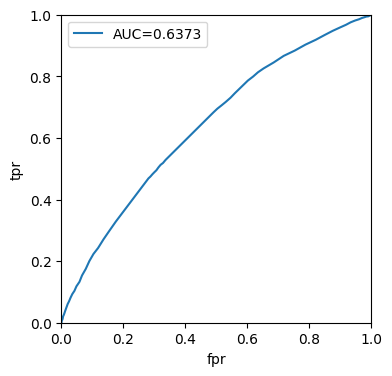

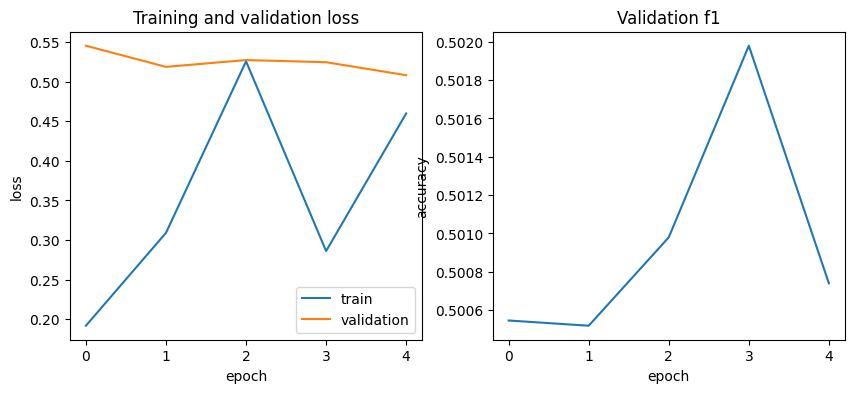

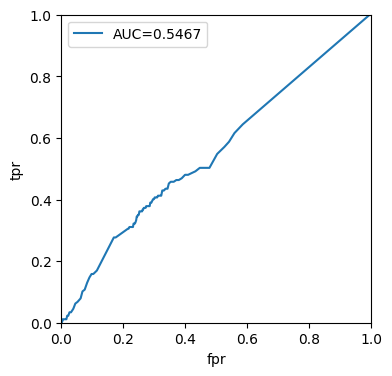

In [45]:
ans = []
for i in Attributes:
    Train(i)
    print(i+' Finished')


In [46]:

Output = pd.DataFrame(ans,columns=['ID','CHANNEL_A','CHANNEL_B','CHANNEL_C'],index=None)
Output

ValueError: 4 columns passed, passed data had 50001 columns

In [ ]:
Output.to_csv("output.csv",index=False)

{'CHANNEL_A': {'booster': 'gbtree',
  'objective': 'binary:logistic',
  'eval_metric': 'error',
  'max_depth': 8,
  'lambda': 2,
  'gamma': 0.1,
  'subsample': 0.85,
  'colsample_bytree': 0.75,
  'min_child_weight': 1,
  'eta': 0.015,
  'nthread': -1,
  'scale_pos_weight': 110.42061281337047},
 'CHANNEL_B': {'booster': 'gbtree',
  'objective': 'binary:logistic',
  'eval_metric': 'error',
  'max_depth': 8,
  'lambda': 2,
  'gamma': 1,
  'subsample': 0.85,
  'colsample_bytree': 0.75,
  'min_child_weight': 4,
  'eta': 0.015,
  'nthread': -1,
  'scale_pos_weight': 110.42061281337047},
 'CHANNEL_C': {'booster': 'gbtree',
  'objective': 'binary:logistic',
  'eval_metric': 'error',
  'max_depth': 9,
  'lambda': 2,
  'gamma': 0.75,
  'subsample': 0.65,
  'colsample_bytree': 0.8,
  'min_child_weight': 4,
  'eta': 0.015,
  'nthread': -1,
  'scale_pos_weight': 110.42061281337047}}